Lab 4: Exploring Image Data

Business Understanding ...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import random
import os
# importing helperp (Code writtern as a script)
import helper
import pandas as pd
import warnings
from sklearn.decomposition import RandomizedPCA
warnings.simplefilter("ignore")

### 1.2 Data preparation

Loading the test and training data. Functions defined in helper.py

Shape of train_images:  (60000, 784)
Shape of train_labels:  (60000,)
Shape of test_images:  (10000, 784)
Shape of test_labels:  (10000,)


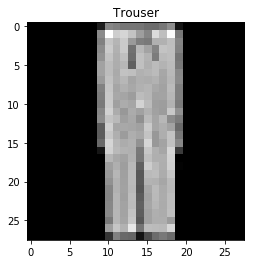

In [2]:
test_images, test_labels = helper.load_test_data()
train_images, train_labels = helper.load_train_data()

labels = { 
            0:'T-shirt/top',
            1:'Trouser',
            2:'Pullover',
            3:'Dress',
            4:'Coat',
            5:'Sandal',
            6:'Shirt',
            7:'Sneaker',
            8:'Bag',
            9:'Ankle boot'
            }
h = 28
w = 28
# Let's varify that the data is loaded correctly
print('Shape of train_images: ',train_images.shape)
print('Shape of train_labels: ',train_labels.shape)
print('Shape of test_images: ',test_images.shape)
print('Shape of test_labels: ',test_labels.shape)

# Load up a random image from training_images
random_index = random.randrange(len(train_images))
label_num_for_image = train_labels[random_index]
label = labels[label_num_for_image]
label
helper.show_image(train_images[random_index],label)

This shows that the dataset has been loaded correctly.

Preview some random images from the training set.

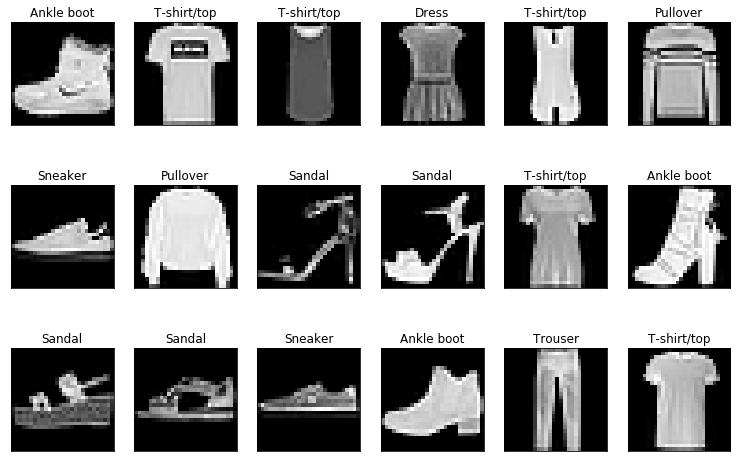

In [3]:
# Let's look at a few more images with labels
def plot_gallery(images, titles,labels, h=28, w=28, n_row=3, n_col=6, uselabels=True):
    """Helper function to plot a gallery of items"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        if(uselabels):
            plt.title(labels[titles[i]], size=12)
        else:
            plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
plot_gallery(train_images, train_labels,labels, 28, 28)# defaults to showing a 3 by 6 subset of the images

## 2. Evaluation

### 2.1 Evaluate metric

Let's first take a look at the number of instances in each class within traininig data. 

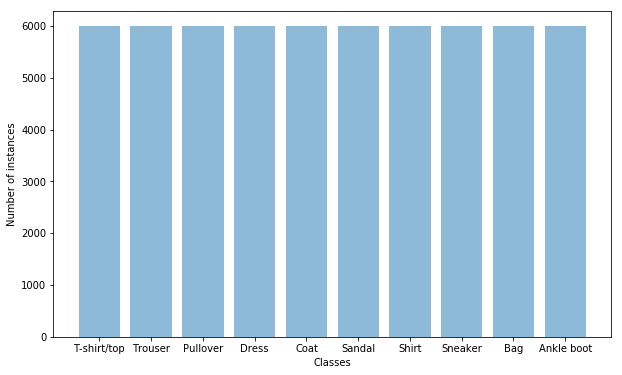

In [4]:
class_counts = np.bincount(train_labels)
y_pos = np.arange(len(class_counts))
fig, ax = plt.subplots(figsize=(10,6))
plt.bar(y_pos, class_counts ,align='center', alpha=0.5)
plt.xticks(y_pos, [labels[x] for x in labels.keys()])
plt.ylabel('Number of instances')
plt.xlabel('Classes')

### 2.2 Evaluate method: crossvalidation 10 folds

## Model (Multi layer perceptron)

### 3.1 Model with one hidden layer

In [5]:
from scipy.special import expit
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None,
                firstLayerActivationFunction = 'sigmoid',
                costFunction = 'quadratic'):# Edit by Zheng Li
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.firstLayerActivationFunction = firstLayerActivationFunction  # Edit by Zheng Li
        self.costFunction = 'quadratic'
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        if self.costFunction =='quadratic':
            cost = np.mean((Y_enc-A3)**2)
        elif self.costFunction =='cross entropy':
            cost = -[Y_enc*math.log(A3)+(1-Y_enc)*math.log(1-A3)]    
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term

In [6]:
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = self._add_bias_unit(X, how='column')
        Z1 = W1 @ A1.T
        if self.firstLayerActivationFunction =='sigmoid': # Edit by Zheng Li
            A2 = self._sigmoid(Z1)
        elif self.firstLayerActivationFunction =='linear':# Edit by Zheng Li
            A2 = Z1  
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # backpropagation
        grad1 = np.zeros(W1.shape)
        grad2 = np.zeros(W2.shape)
        
        # for each instance's activations 
        for (a1,a2,a3,y) in zip(A1,A2.T,A3.T,Y_enc.T):
            dJ_dz2 = -2*(y - a3)*a3*(1-a3)
            dJ_dz1 = dJ_dz2 @ W2 @ np.diag(a2*(1-a2))
            grad2 += dJ_dz2[:,np.newaxis]  @ a2[np.newaxis,:]
            grad1 += dJ_dz1[1:,np.newaxis] @ a1[np.newaxis,:] 
            # don't incorporate bias term in the z1 gradient 
            # (its added in a2 from another layer)
            

        # regularize weights that are not bias terms
        grad1[:, 1:] += (W1[:, 1:] * self.l2_C)
        grad2[:, 1:] += (W2[:, 1:] * self.l2_C)

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3 = self._feedforward(X_data,self.W1,self.W2)
            
            cost = self._cost(A3,Y_enc,self.W1,self.W2)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, Y_enc=Y_enc,
                                              W1=self.W1, W2=self.W2)

            self.W1 -= self.eta * grad1
            self.W2 -= self.eta * grad2
            

        return self

In [7]:
class TwoLayerPerceptronVectorized(TwoLayerPerceptron):
    # just need a different gradient calculation
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        if self.costFunction =='quadratic':
            sigma2 = -2*(Y_enc-A3)*A3*(1-A3)
        elif self.costFunction =='cross entropy':
            sigma2 = (A3-Y_enc)
            # vectorized backpropagation   
        grad2 = sigma2 @ A2.T

        sigma1 = (W2.T @ sigma2)*A2*(1-A2)
        grad1 = sigma1[1:,:] @ A1
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2

### 3.2 Parameter tuning

In [30]:
from sklearn.model_selection import train_test_split


params = dict(n_hidden1=128,
               n_hidden2= 64,
              C=0.01, # tradeoff L2 regularizer
              epochs=100, # iterations
              eta=0.0001,  # learning rate
              random_state=1,
              firstLayerActivationFunction='sigmoid',
              secondLayerActivationFunction='sigmoid',
              costFunction = 'quadratic')

X = train_images[:6000]  
y = train_labels[:6000]



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=256,random_state=1)),
                    ('clf', ThreeLayerPerceptronVectorized(**params))])

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print("Accuracy score of: ",accuracy_score(y_test,y_pred))

In [27]:
eta = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
score = []
for i in eta:
    params['eta']=i
    pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=256,random_state=1)),
                    ('clf', ThreeLayerPerceptronVectorized(**params))])

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print("Accuracy score of: ",accuracy_score(y_test,y_pred))_components=256,random_state=1)),
                    ('clf', ThreeLayerPerceptronVectorized(**params))])
    pipe_lr.fit(X_train, y_train)
    y_pred = pipe_lr.predict(X_test)
    scr = accuracy_score(y_test,y_pred)
    score.append(scr)
    print("Accuracy score of: %.3f for learning rate: %f"%(scr,i))

Accuracy score of: 0.108 for learning rate: 0.100000
Accuracy score of: 0.108 for learning rate: 0.010000
Accuracy score of: 0.268 for learning rate: 0.001000
Accuracy score of: 0.562 for learning rate: 0.000100
Accuracy score of: 0.144 for learning rate: 0.000010
Accuracy score of: 0.097 for learning rate: 0.000001


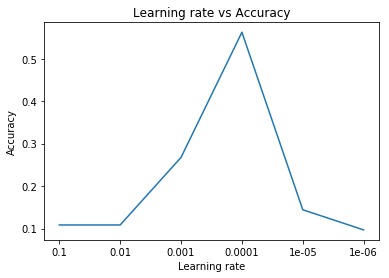

In [28]:
x_ = list(i for i in range(6))
plt.plot(score)
plt.xticks(x_,eta)
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
plt.title("Learning rate vs Accuracy")
plt.show()

According to the learning rate vs Accuracy, learning rate of 0.0001 has the best performance, therefore, the following analysis will use the value of 0.0001 as learning rate

In [31]:
C = [10,1, 0.1, 0.01, 0.001, 0.0001]
score = []
for i in C:
    params['C']=i
    pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=256,random_state=1)),
                    ('clf', ThreeLayerPerceptronVectorized(**params))])
    pipe_lr.fit(X_train, y_train)
    y_pred = pipe_lr.predict(X_test)
    scr = accuracy_score(y_test,y_pred)
    score.append(scr)
    print("Accuracy score of: %.3f for Regularization term C: %f"%(scr,i))

Accuracy score of: 0.647 for Regularization term C: 100.000000
Accuracy score of: 0.583 for Regularization term C: 10.000000
Accuracy score of: 0.565 for Regularization term C: 1.000000
Accuracy score of: 0.563 for Regularization term C: 0.100000
Accuracy score of: 0.562 for Regularization term C: 0.010000
Accuracy score of: 0.562 for Regularization term C: 0.001000
Accuracy score of: 0.562 for Regularization term C: 0.000100


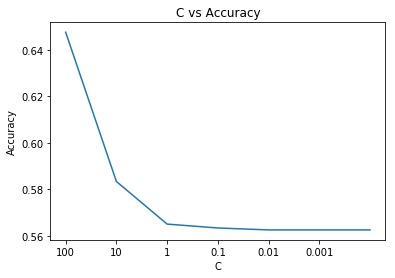

In [32]:
x_ = list(i for i in range(6))
plt.plot(score)
plt.xticks(x_,C)
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("C vs Accuracy")
plt.show()

According to the C vs Accuracy, C =10 has the best performance, therefore, the following analysis will use the value of 10 as regularization term

In [35]:
params = dict(n_hidden1=128,
               n_hidden2= 64,
              C=10, # tradeoff L2 regularizer
              epochs=100, # iterations
              eta=0.0001,  # learning rate
              random_state=1,
              firstLayerActivationFunction='sigmoid',
              secondLayerActivationFunction='sigmoid',
              costFunction = 'quadratic')

epochs = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
score_test = []
score_val = []
X_val = test_images
y_val = test_labels

for i in epochs:
    params['epochs']=i
    pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=256,random_state=1)),
                    ('clf', ThreeLayerPerceptronVectorized(**params))])
    pipe_lr.fit(X_train, y_train)
    y_pred = pipe_lr.predict(X_test)
    y_pred_val = pipe_lr.predict(X_val)
    test_scr = accuracy_score(y_test,y_pred)
    val_scr = accuracy_score(y_val,y_pred_val)
    score_test.append(test_scr)
    score_val.append(val_scr)
    print("Test Accuracy: %.3f Validation Accuracy: %.3f for Epochs: %i"%(test_scr, val_scr, i))

Test Accuracy: 0.583 Validation Accuracy: 0.556 for Epochs: 100
Test Accuracy: 0.692 Validation Accuracy: 0.678 for Epochs: 200
Test Accuracy: 0.743 Validation Accuracy: 0.725 for Epochs: 300
Test Accuracy: 0.773 Validation Accuracy: 0.753 for Epochs: 400
Test Accuracy: 0.787 Validation Accuracy: 0.769 for Epochs: 500
Test Accuracy: 0.797 Validation Accuracy: 0.780 for Epochs: 600
Test Accuracy: 0.805 Validation Accuracy: 0.787 for Epochs: 700
Test Accuracy: 0.818 Validation Accuracy: 0.793 for Epochs: 800
Test Accuracy: 0.825 Validation Accuracy: 0.800 for Epochs: 900
Test Accuracy: 0.833 Validation Accuracy: 0.806 for Epochs: 1000


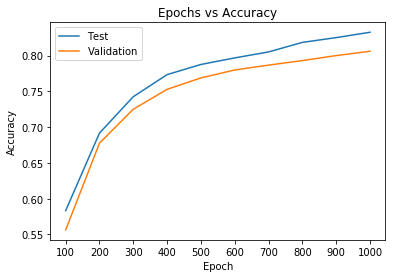

In [36]:
x_ = list(i for i in range(10))
plt.plot(score_test)
plt.plot(score_val)
plt.xticks(x_,epochs)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epochs vs Accuracy")
plt.legend(["Test","Validation"])
plt.show()

In [37]:
from sklearn.model_selection import StratifiedKFold
X = test_images
y = test_labels

kfold = StratifiedKFold(n_splits=10,
                        random_state=1, shuffle=True).split(X, y)
params = dict(n_hidden1=128,
               n_hidden2= 64,
              C=10, # tradeoff L2 regularizer
              epochs=1000, # iterations
              eta=0.0001,  # learning rate
              random_state=1,
              firstLayerActivationFunction='sigmoid',
              secondLayerActivationFunction='sigmoid',
              costFunction = 'quadratic')

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=256,random_state=1)),
                    ('clf', ThreeLayerPerceptronVectorized(**params))])

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X[train], y[train])
    y_pred = pipe_lr.predict(X[test])
    score = accuracy_score(y[test],y_pred)
    scores.append(score)
    print('Fold: %s, Acc: %.3f' % (k+1, score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Acc: 0.820
Fold: 2, Acc: 0.827
Fold: 3, Acc: 0.818
Fold: 4, Acc: 0.828
Fold: 5, Acc: 0.818
Fold: 6, Acc: 0.818
Fold: 7, Acc: 0.811
Fold: 8, Acc: 0.845
Fold: 9, Acc: 0.838
Fold: 10, Acc: 0.823

CV accuracy: 0.825 +/- 0.010


### Given the best parameters, we managed to reach 82.5%+/- 0.01 test accuracy

### 3.3 Performance Comparison 

In [38]:
from sklearn import __version__ as sklearn_version
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

print("Sci-kit Learn Implementation")
print(sklearn_version)
# these values have been hand tuned
params = dict(hidden_layer_sizes=(50, ), 
                    activation='logistic', 
                    solver='sgd', 
                    alpha=1e-4, # L2 penalty
                    batch_size='auto', # min of 200, num_samples
                    learning_rate='constant', 
                    learning_rate_init=0.0001, # only SGD
                    power_t=0.5,    # only SGD
                    max_iter=800, 
                    shuffle=True, 
                    random_state=1, 
                    tol=1e-9, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    momentum=0.9, # only SGD
                    nesterovs_momentum=True, # only SGD
                    early_stopping=False, 
                    validation_fraction=0.1, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.999, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=256,random_state=1)),
                    ('clf', MLPClassifier(**params))])

%time pipe_lr.fit(X_train,y_train)
yhat = pipe_lr.predict(X_val)
print('Validation Acc:',accuracy_score(yhat,y_val))

Sci-kit Learn Implementation
0.19.0
CPU times: user 50.1 s, sys: 8.67 s, total: 58.8 s
Wall time: 35.7 s
Validation Acc: 0.7647


In [39]:
print("Our Implementation")

params = dict(n_hidden1=128,
               n_hidden2= 64,
              C=10, # tradeoff L2 regularizer
              epochs=1000, # iterations
              eta=0.0001,  # learning rate
              random_state=1,
              firstLayerActivationFunction='sigmoid',
              secondLayerActivationFunction='sigmoid',
              costFunction = 'quadratic')

X = train_images[:6000]  
y = train_labels[:6000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=256,random_state=1)),
                    ('clf', ThreeLayerPerceptronVectorized(**params))])

%time pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_val)
print("Accuracy score of: ",accuracy_score(y_pred,y_val))

Our Implementation
CPU times: user 1min 32s, sys: 20.8 s, total: 1min 53s
Wall time: 1min 1s
Accuracy score of:  0.8059


The comparison between our implementatioin and sklearn has been conducted, our best performancea reaches 80.59% on the validation set and the sklearn reaches 76.47% on the validation set. In terms of running time, our implementation used 1min 53s and sklearn used 58.8s. In all, the sklearn outperforms our implementation in computational time but not on accruacy. It is worth mentioning that we have used additional layer for our MLP(three layer MLP) and the performance of our implementation could be improved further by applying optimization techniques like dropout, various activation functions, softmax, etc. 

## Exceptional work